In [8]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import pandas as pd

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

from tools.log_progress import log_progress

int_dir = os.path.join(data_dir,'analysis','interim')
fig_dir = os.path.join(os.pardir,os.pardir,'reports','figures')
grid_path = os.path.join(data_dir,'analysis','interim','grd2_dV.nc')
m_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_m_avg.nc')
temp_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_temp_avg.nc')

In [29]:
from dask.distributed import Client
c = Client()
c

Client Scheduler: tcp://127.0.0.1:44403 Dashboard: http://127.0.0.1:51649/status,Cluster Workers: 16 Cores: 16 Memory: 101.38 GB


In [31]:
grd = xr.open_dataset(grid_path)

m = xr.open_dataset(m_path).m.squeeze()
temp = xr.open_mfdataset(temp_path).temp.squeeze()

s2a = 3600*24*365.25
rhoi = 916

## calculate ismr and continental shelf deep ocean temps for each sector

In [3]:
mask_sector_path = os.path.join(int_dir,'mask_sector2.npy')
mask_sector = np.load(mask_sector_path).item()

In [17]:
ismr = {}

for sec_key,sec_mask in log_progress(mask_sector.items(),name='sector'):
        
    mask = (sec_mask==1) & (grd.mask_rho==1) & (grd.zice<0.0)

    dA = (1/(grd.pm*grd.pn)).where(mask)
    weights = dA/dA.sum()

    ismr[sec_key] = (m.where(mask)*weights).sum().values*s2a

In [27]:
mask_shelf_path = os.path.join(int_dir,'mask_shelf_2.npy')
mask_shelf = np.load(mask_shelf_path)
mask_shelf = xr.DataArray(mask_shelf,dims=('eta_rho','xi_rho'))

In [32]:
temp_deep = {}

mask_cavity =  (grd.mask_rho == 1) & (grd.zice < 0.0)

for sec_name,sec_mask in log_progress(mask_sector.items()):
    
        mask = (sec_mask==1) & (grd.z<-400) & (mask_shelf==1) & (mask_cavity==0)
    
        dV = grd.dV.where(mask)
        weights = dV/dV.sum()
    
        temp_deep[sec_name] = (temp.where(mask)*weights).sum().values*1.0

In [49]:
max_temp = temp_deep[max(temp_deep,key=temp_deep.get)]+1.9
max_ismr = ismr[max(ismr,key=ismr.get)]

In [70]:
mask_sector["Sabrina Coast"] = mask_sector.pop('Sabrina Coast/Aurora subglacial basin')
mask_sector['George V Coast'] = mask_sector.pop('George V Coast/Wilkes subglacial basin')
mask_sector['Prydz Bay'] = mask_sector.pop('Amery/Prydz Bay')

In [73]:
ismr["Sabrina Coast"] = ismr.pop('Sabrina Coast/Aurora subglacial basin')
ismr['George V Coast'] = ismr.pop('George V Coast/Wilkes subglacial basin')
ismr['Prydz Bay'] = ismr.pop('Amery/Prydz Bay')

In [74]:
temp_deep["Sabrina Coast"] = temp_deep.pop('Sabrina Coast/Aurora subglacial basin')
temp_deep['George V Coast'] = temp_deep.pop('George V Coast/Wilkes subglacial basin')
temp_deep['Prydz Bay'] = temp_deep.pop('Amery/Prydz Bay')

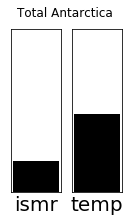

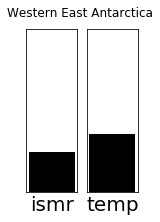

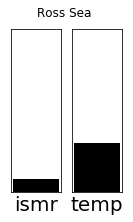

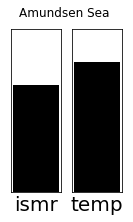

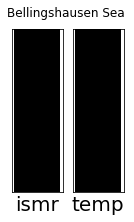

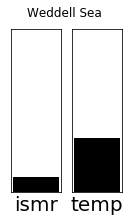

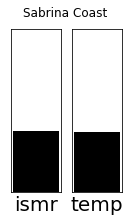

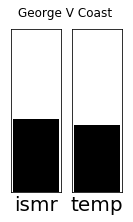

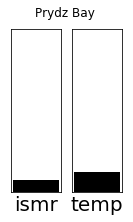

In [83]:
plt.close()
for key,data in mask_sector.items():
    fig,axes = plt.subplots(ncols=2,figsize=(2,3))
    ax1,ax2 = axes.flatten()
    fig.suptitle(key)
    ax1.bar(0,ismr[key],color='k')
    ax2.bar(0,temp_deep[key]+1.9,color='k')
    ax1.set_ylim([0,max_ismr])
    ax1.set_xlabel('ismr',fontsize=20)
    ax2.set_ylim([0,max_temp])
    ax2.set_xlabel('temp',fontsize=20)
    for ax in axes.flatten():
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
    plt.savefig(os.path.join(fig_dir,'tmp','ismr_vs_deepTemp_'+key.replace('/','_'))+'.png',format='png',
                transparent=True,dpi=300)
    plt.show()

## histogram plots for A, bmb and ismr

In [25]:
A_max = df.drop(columns='Total Antarctica').T['A all'].max()
bmb_max = df.drop(columns='Total Antarctica').T['bmb all'].max()
ismr_max = df.drop(columns='Total Antarctica').T['ismr all'].max()

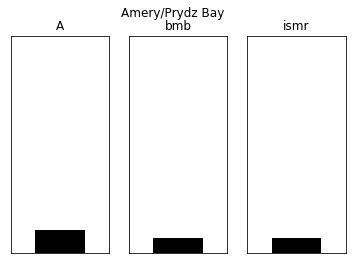

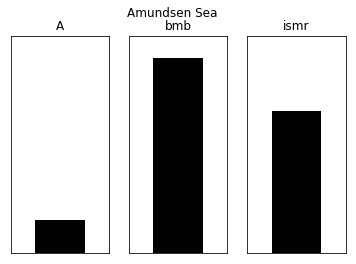

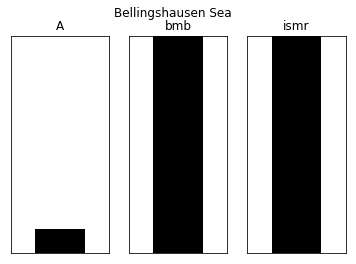

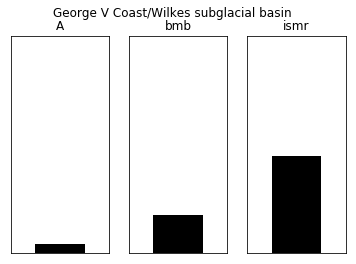

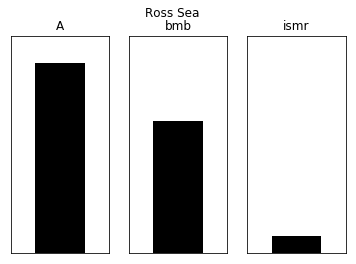

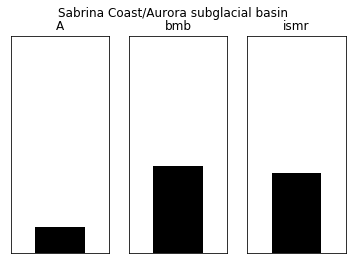

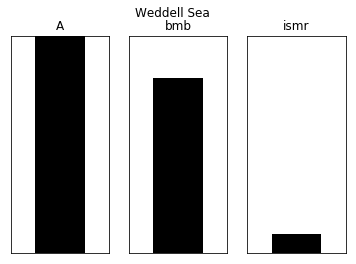

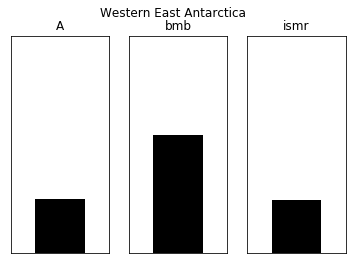

In [41]:
plt.close()
for sec_name,sec_data in df.drop(columns='Total Antarctica').items():
    fig,axes = plt.subplots(ncols=3)
    fig.suptitle(sec_name)
    for ax,key in zip(axes.flatten(),['A','bmb','ismr']):
        sec_data.loc[[key+' all']].plot.bar(ax=ax,use_index=False,color='k')
        ax.set_ylim(0,df.drop(columns='Total Antarctica').T[key+' all'].max())
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(key)
    #plt.tight_layout()    
    plt.savefig(os.path.join(fig_dir,'tmp','all_'+sec_key.replace('/','_'))+'.png',format='png',transparent=True)
    plt.show()

<Figure size 1080x720 with 0 Axes>

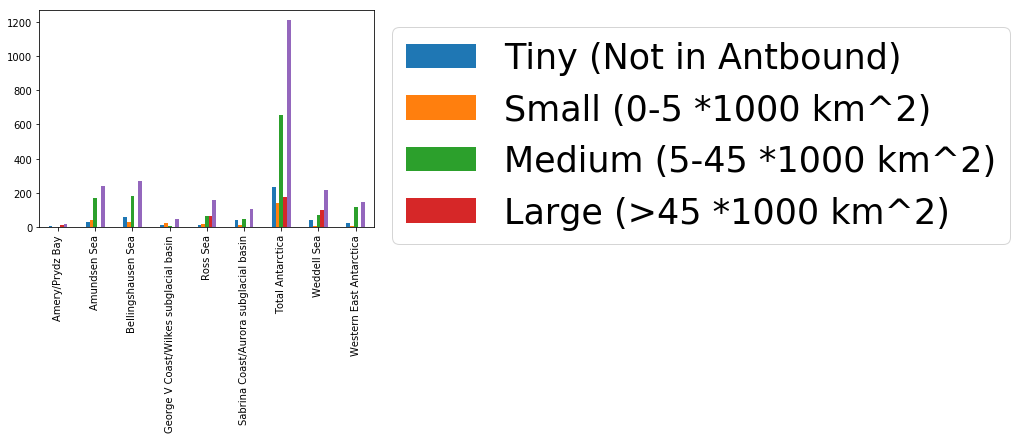

In [332]:
plt.close()
fig = plt.figure(figsize=(15,10))
df.loc[['bmb tiny','bmb small','bmb medium','bmb large','bmb all']].T.plot.bar(legend=True)
plt.legend(['Tiny (Not in Antbound)','Small (0-5 *1000 km^2)','Medium (5-45 *1000 km^2)','Large (>45 *1000 km^2)'],fontsize=35,
          bbox_to_anchor=(1,1))
plt.savefig(os.path.join(fig_dir,'tmp','pie_legend.png'),transparent=True,bbox_inches='tight')
plt.show()

## continental shelf temps vs ismr

## calculate average on shelf temps (shallow, deep, cavity) for sectors

In [11]:
# equip roms grid with depths and volumes
from tools.cartesian_grid_3d import cartesian_grid_3d

lon_u = grd.lon_u.values
lat_u = grd.lat_u.values
lon_v = grd.lon_v.values
lat_v = grd.lat_v.values
h = grd.h.values
zice = grd.zice.values
theta_s = 7#zeta.theta_s.values
theta_b = 8#zeta.theta_b.values
hc = 250#temp.hc.values
N = temp.s_rho.size

dx,dy,dz,z = cartesian_grid_3d(lon_u, lat_u, lon_v, lat_v, h, zice, theta_s, theta_b, hc, N, zeta.values)

grd['dx'] = xr.DataArray(dx,dims=['s_rho','eta_rho','xi_rho'])
grd['dx'] = grd.dx.where(grd.mask_rho == 1)

grd['dy'] = xr.DataArray(dy,dims=['s_rho','eta_rho','xi_rho'])
grd['dy'] = grd.dy.where(grd.mask_rho == 1)

grd['dz'] = xr.DataArray(dz,dims=['s_rho','eta_rho','xi_rho'])
grd['dz'] = grd.dz.where(grd.mask_rho == 1)

grd['z'] = xr.DataArray(z,dims=['s_rho','eta_rho','xi_rho'])
grd['z'] = grd.z.where(grd.mask_rho == 1)

dV = grd.dx * grd.dy * grd.dz
grd['dV'] = dV

NameError: name 'zeta' is not defined

In [40]:
grd_out_path = os.path.join(int_dir,'grd2_dV.nc')
grd.to_netcdf(grd_out_path)

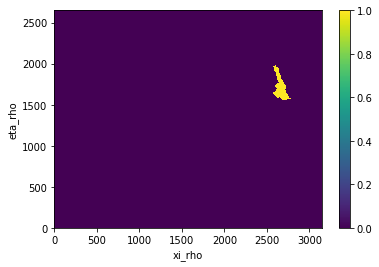

In [77]:
mask_cavity = (grd.mask_rho == 1) & (grd.zice < 0.0)
mask =mask_shelf_sector['Amery/Prydz Bay']

plt.close()
mask.plot()
plt.show()

In [115]:
sec_depth_temp = {}

mask_cavity =  (grd.mask_rho == 1) & (grd.zice < 0.0)
mask_shelf = mask_shelf_sector['Total Antarctica']

for sec_name,sec_mask in log_progress(mask_sector.items()):
    sec_depth_temp[sec_name]={}
    
    for depth_name,depth_mask in zip(['shallow'],[(mask_shelf | mask_cavity) & (grd.z >= -200)]):
    #zip(['all','cavity','shelf','100','200','350','500'],
                                 #    [mask_cavity | mask_shelf,mask_cavity,mask_shelf,
                                 #     (mask_shelf == 1) & (grd.z < -100),
                                 #     (mask_shelf == 1) & (grd.z < -200),
                                 #    (mask_shelf == 1) & (grd.z < -350),
                                 #    (mask_shelf == 1) & (grd.z < -500)]): 
    
        mask = sec_mask & depth_mask
    
        dV = grd.dV.where(mask)
        weights = dV/dV.sum()
    
        sec_depth_temp[sec_name][depth_name] = (temp.where(mask)*weights).sum().values*1.0

In [119]:
for sec_name,sec_mask in log_progress(mask_shelf_sector.items()):
    
    mask = (sec_mask==1) & (grd.zice < 0.0) & (grd.mask_rho==1)
    
    sec_depth_temp[sec_name]['avg draft'] = grd.zice.where(mask).mean().values*1.0

In [120]:
df_temp = pd.DataFrame.from_dict(sec_depth_temp, orient='index').T

df_out_path = os.path.join(int_dir,'temp.csv')
df_temp.to_csv(df_out_path)

In [121]:
df = pd.concat([df_melt,df_temp])

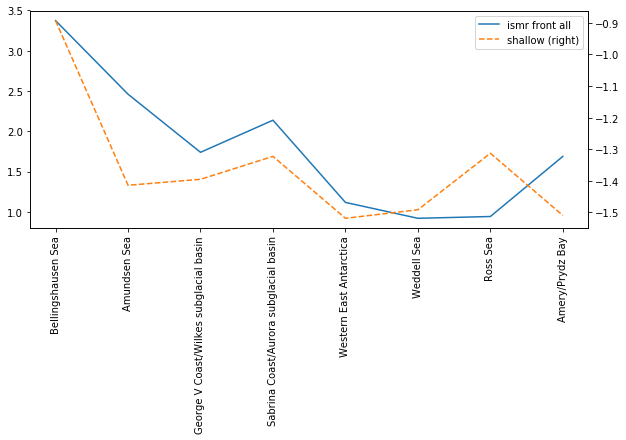

In [124]:
df_plt = df.T.drop('Total Antarctica').sort_values('ismr all',ascending=False)
plt.close()
fig,ax = plt.subplots(figsize=(10,4))
df_plt.plot(y='ismr front all',ax=ax)
df_plt.plot(y='shallow',linestyle='dashed',ax=ax,xticks=range(8),rot=90,secondary_y=True)
#df_plt.plot(y='avg draft',ax=ax2,xticks=range(8),rot=90)
#df_plt.plot(y='ismr front all',ax=ax,xticks=range(8),rot=90,secondary_y=True)

#plt.savefig(os.path.join(fig_dir,'tmp','ismr_vs_temps.png'),bbox_inches='tight')
plt.show()

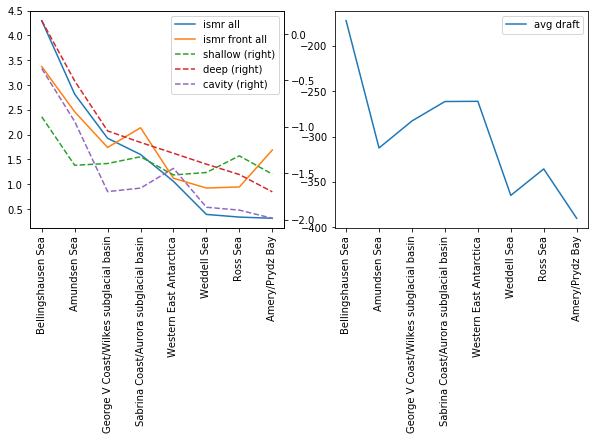

In [39]:
df_plt = df.T.drop('Total Antarctica').sort_values('ismr all',ascending=False)
plt.close()
fig,axes = plt.subplots(ncols=2,figsize=(10,4))
ax1,ax2 = axes.flatten()
df_plt.plot(y=['ismr all','ismr front all'],ax=ax1)
df_plt.plot(y=['shallow','deep','cavity'],linestyle='dashed',ax=ax1,xticks=range(8),rot=90,secondary_y=True)
df_plt.plot(y='avg draft',ax=ax2,xticks=range(8),rot=90)
#df_plt.plot(y='ismr front all',ax=ax,xticks=range(8),rot=90,secondary_y=True)

plt.savefig(os.path.join(fig_dir,'tmp','ismr_vs_temps.png'),bbox_inches='tight')
plt.show()

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


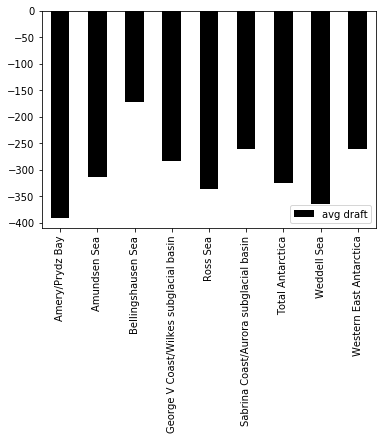

In [52]:
plt.close()
fig,ax = plt.subplots()
df.T.plot.bar(y=['avg draft'],colors='k',ax=ax)
#df.T.plot.bar(y=['avg draft'],secondary_y=True,colors='k',ax=ax)

plt.show()

In [376]:
def make_sector(mask_sector,name_sector):
    
    sector = {}
    
    mask = mask_sector & (grd.mask_rho==1) & (grd.zice<0)

    dA = (1/(grd.pm*grd.pn)).where(mask)
    weights = dA/dA.sum()

    ismr2bmb = dA*rhoi*(10**-12)

    sector["A total"] = dA.sum().values*10**-9
    sector["ismr total"] = (m.where(mask)*weights).sum().values*s2a
    sector["bmb total"] = (m.where(mask)*ismr2bmb).sum().values*s2a
    
    for k,v in mask_size.items():
        
        mask = mask_sector & (grd.mask_rho==1) & (grd.zice<0) & (v==1)

        dA = (1/(grd.pm*grd.pn)).where(mask)
        weights = dA/dA.sum()

        ismr2bmb = dA*rhoi*(10**-12)

        sector["A "+k] = dA.sum().values*10**-9
        sector["ismr "+k] = (m.where(mask)*weights).sum().values*s2a
        sector["bmb "+k] = (m.where(mask)*ismr2bmb).sum().values*s2a
    
    sector_df = pd.DataFrame.from_dict({name_sector:sector}, orient='index').dropna()
    
    return sector_df

In [389]:
for k,v in mask_sectors.items():  
    all_ice_df = all_ice_df.append(make_sector(v,k))


In [390]:
all_ice_df

,A total,ismr total,bmb total,A small,ismr small,bmb small,A medium,ismr medium,bmb medium,A large,ismr large,bmb large
all ice,"1,633.13",0.81,"1,209.32",72.56,2.16,143.77,422.29,1.69,653.75,"1,028.48",0.19,176.49
Western East Antarctica,65.53,0.31,18.51,1.81,0.76,1.26,0.00,0.00,0.00,59.13,0.20,10.57
Amery/Prydz Bay,88.77,1.33,108.20,8.69,1.90,15.17,51.92,1.05,49.85,0.00,0.00,0.00
Sabrina Coast/Aurora subglacial basin,27.17,1.93,47.92,13.44,2.15,26.50,5.31,1.36,6.61,0.14,1.49,0.20


In [324]:
mask_Ronne = make_mask_lonlat(grd,-85,-49.5,-84.50,-74.7)
mask_Filchner = make_mask_lonlat(grd,-49.5,-27.66,-83.5,-77.73)
mask_FRIS = mask_Filchner | mask_Ronne

mask_Amery = make_mask_lonlat(grd,65,74.3,-73.7,-68.3) 

mask_RossIS_West = make_mask_lonlat(grd,-180,-146.70,-86,-77.8)
mask_RossIS_East = make_mask_lonlat(grd,158.3,180,-84.5,-77)
mask_RossIS = mask_RossIS_West | mask_RossIS_East

mask_Larsen = make_mask_lonlat(grd,-65.5,-60,-69.3,-66.1)

vostock = (grd.lat_rho<-75) & (grd.lat_rho>-80) & (grd.lon_rho>95) & (grd.lon_rho<115)

mask_BA = make_mask_lonlat(grd,-141,-65.5,-90,-60) & ~mask_FRIS
mask_Ross = make_mask_lonlat(grd,160,-141,-90,-60)
mask_EI = make_mask_lonlat(grd,94.2,160,-90,-60) & ~vostock
mask_WI = make_mask_lonlat(grd,7.6,94.2,-90,-60)
mask_Weddell = make_mask_lonlat(grd,-65.5,7.6,-90,-60) | mask_FRIS

True

In [230]:
all_ice = {}

ice_shelf = (grd.mask_rho==1) & (grd.zice<0.0) 
vostock = (grd.lat_rho<-75) & (grd.lat_rho>-80) & (grd.lon_rho>95) & (grd.lon_rho<115)

mask = ice_shelf & ~vostock

dA = (1/(grd.pm*grd.pn)).where(mask)
weights = dA/dA.sum()

ismr2bmb = dA*rhoi*(10**-12)

all_ice["A"] = dA.sum().values*10**-9
all_ice["ismr"] = (m.where(mask)*weights).sum().values*s2a
all_ice["bmb"] = (m.where(mask)*ismr2bmb).sum().values*s2a

mask = mask & (grd.mask_front == 0)

dA = (1/(grd.pm*grd.pn)).where(mask)
weights = dA/dA.sum()

ismr2bmb = dA*rhoi*(10**-12)

all_ice["A_nf"] = dA.sum().values*10**-9
all_ice["ismr_nf"] = (m.where(mask)*weights).sum().values*s2a
all_ice["bmb_nf"] = (m.where(mask)*ismr2bmb).sum().values*s2a

mask = (grd.h < 1000.0) & (grd.zice == 0.0) & (grd.mask_rho == 1)
    
dA = (1/(grd.pm*grd.pn)).where(mask)
weights = dA/dA.sum()
    
all_ice["theta"] = (temp.where(mask)*weights).sum().values

all_ice = pd.DataFrame.from_dict({'All ice (Bedmap2)':all_ice}, orient='index',
                            columns=['bmb','bmb_nf','ismr','ismr_nf','A','A_nf','theta']).dropna()
all_ice

,bmb,bmb_nf,ismr,ismr_nf,A,A_nf,theta
All ice (Bedmap2),"1,209.20",829.00,0.82,0.61,"1,617.62","1,475.80",-0.917126956575405


# Ice by ocean sector

In [226]:
def make_mask_lonlat(grd,lon_min,lon_max,lat_min,lat_max):

    if lon_min<lon_max:
        mask_lonlat = (grd.lon_rho>lon_min) & (grd.lon_rho<=lon_max) & (grd.lat_rho>lat_min) & (grd.lat_rho<=lat_max)
    else:
        mask_lonlat = ((grd.lon_rho>lon_min) | (grd.lon_rho<=lon_max)) & (grd.lat_rho>lat_min) & (grd.lat_rho<=lat_max)

    
    return mask_lonlat  

In [278]:
mask_Ronne = make_mask_lonlat(grd,-85,-49.5,-84.50,-74.7)
mask_Filchner = make_mask_lonlat(grd,-49.5,-27.66,-83.5,-77.73)
mask_FRIS = mask_Filchner | mask_Ronne

mask_Amery = make_mask_lonlat(grd,65,74.3,-73.7,-68.3) 

mask_RossIS_West = make_mask_lonlat(grd,-180,-146.70,-86,-77.8)
mask_RossIS_East = make_mask_lonlat(grd,158.3,180,-84.5,-77)
mask_RossIS = mask_RossIS_West | mask_RossIS_East

mask_Larsen = make_mask_lonlat(grd,-65.5,-60,-69.3,-66.1)

vostock = (grd.lat_rho<-75) & (grd.lat_rho>-80) & (grd.lon_rho>95) & (grd.lon_rho<115)

mask_BA = make_mask_lonlat(grd,-141,-65.5,-90,-60) & ~mask_FRIS
mask_Ross = make_mask_lonlat(grd,160,-141,-90,-60)
mask_EI = make_mask_lonlat(grd,94.2,160,-90,-60) & ~vostock
mask_WI = make_mask_lonlat(grd,7.6,94.2,-90,-60)
mask_Weddell = make_mask_lonlat(grd,-65.5,7.6,-90,-60) | mask_FRIS

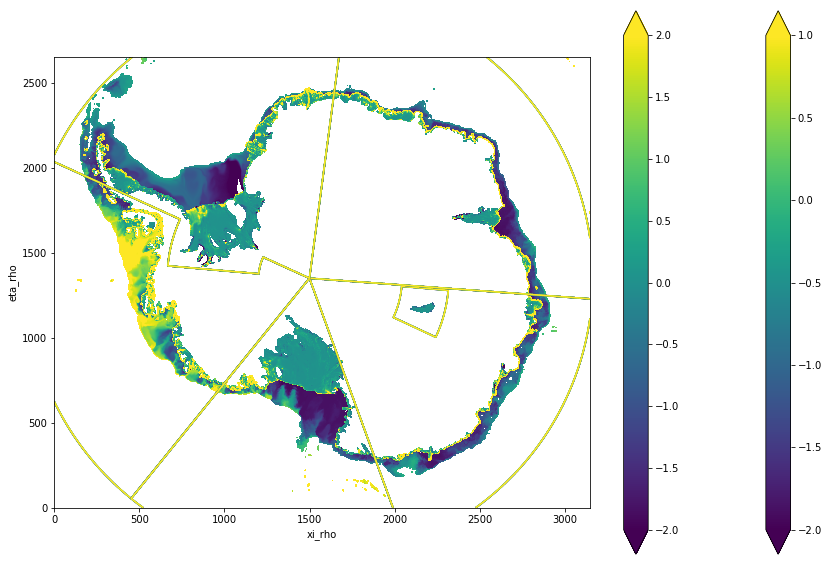

In [279]:
%matplotlib inline



mask_sec = mask_Weddell

mask_ice =  (grd.mask_rho==1) & (grd.zice<0)
mask_temp =  (grd.h < 1000.0) & (grd.mask_rho == 1) & (grd.zice == 0.0)

plt.close()
fig,ax = plt.subplots(figsize=(15,10))
temp.where(mask_temp).plot(ax=ax,vmin=-2,vmax=1)
(m.where(mask_ice)*365*24*3600).plot(ax=ax,vmin=-2,vmax=2)

for mask_sec in [mask_BA,mask_Ross,mask_EI,mask_WI,mask_Weddell]: 
    ax.contour(mask_sec)

ax.set_aspect('equal')
plt.show()

In [244]:
def make_row(mask_ice_sec,mask_temp_sec,name):
    
    row = {}
    
    mask = mask_ice_sec & (grd.mask_rho==1) & (grd.zice<0)

    dA = (1/(grd.pm*grd.pn)).where(mask)
    weights = dA/dA.sum()

    ismr2bmb = dA*rhoi*(10**-12)

    row["A"] = dA.sum().values*10**-9
    row["ismr"] = (m.where(mask)*weights).sum().values*s2a
    row["bmb"] = (m.where(mask)*ismr2bmb).sum().values*s2a
    
    mask = mask & (grd.mask_front==0)
    
    dA = (1/(grd.pm*grd.pn)).where(mask)
    weights = dA/dA.sum()

    ismr2bmb = dA*rhoi*(10**-12)
    
    row["A_nf"] = dA.sum().values*10**-9
    row["ismr_nf"] = (m.where(mask)*weights).sum().values*s2a
    row["bmb_nf"] = (m.where(mask)*ismr2bmb).sum().values*s2a
    
    mask = mask_temp_sec & (grd.h < 1000.0) & (grd.zice == 0.0) & (grd.mask_rho == 1)
    
    dA = (1/(grd.pm*grd.pn)).where(mask)
    weights = dA/dA.sum()
    
    row["theta"] = (temp.where(mask)*weights).sum().values
    
    row = pd.DataFrame.from_dict({name:row}, orient='index',
                                columns=['bmb','bmb_nf','ismr','ismr_nf','A','A_nf','theta']).dropna()
    return row

In [247]:
regime = make_row(mask_BA,mask_BA,'BA all')
regime = regime.append(make_row(mask_lc,(mask_Ross | mask_WI | mask_Weddell),'large cold'))
regime = regime.append(make_row(mask_sc,~mask_BA,'small cold'))
regime

,bmb,bmb_nf,ismr,ismr_nf,A,A_nf,theta
BA all,455.33,331.08,3.23,2.95,153.70,122.33,0.17672571567878018
large cold,182.18,159.27,0.19,0.17,"1,045.17","1,026.66",-1.2912292052461993
small cold,513.92,291.39,1.37,0.99,409.88,319.78,-1.266956116797361


In [271]:
sectors = make_row(mask_BA,mask_BA,'BA Seas')

for mask_ice,mask_temp,name in log_progress(zip([mask_RossIS,(mask_Ross & ~mask_RossIS),
                                                 mask_EI,
                                                 mask_Amery, (mask_WI & ~mask_Amery),
                                                 mask_FRIS,mask_Larsen,(mask_Weddell & ~mask_FRIS)],
                                                [mask_Ross,mask_Ross,
                                                 mask_EI,
                                                 mask_WI,mask_WI,
                                                 mask_Weddell,mask_Weddell,mask_Weddell],
                                                ['Ross','Ross sea small',
                                                 'East Indian sea',
                                                 'Amery','West Indian sea small',
                                                 'FRIS','LarsenC','Weddell Sea small']),every=3):
    sectors = sectors.append(make_row(mask_ice,mask_temp,name))
sectors

,bmb,bmb_nf,ismr,ismr_nf,A,A_nf,theta
BA Seas,455.33,331.08,3.23,2.95,153.70,122.33,0.17672571567878018
Ross,69.15,57.51,0.15,0.13,493.61,485.22,-1.3270077753825582
Ross sea small,96.10,68.40,2.36,2.50,44.54,29.91,-1.3270077753825582
East Indian sea,123.00,54.90,1.75,1.12,76.67,53.64,-1.1762184150101118
Amery,10.04,7.16,0.18,0.13,60.53,58.13,-1.4255533719500193
West Indian sea small,110.28,52.42,1.07,0.66,112.68,86.93,-1.4255533719500193
FRIS,89.87,84.40,0.23,0.21,435.37,430.28,-1.213856715749589
LarsenC,13.13,10.20,0.26,0.21,55.66,53.03,-1.213856715749589
Weddell Sea small,198.31,126.52,0.93,0.68,232.46,203.13,-1.213856715749589


In [272]:
pd.options.display.float_format = '{:,.2f}'.format
out_dir = os.path.join(pro_dir,'2km_mass_loss_ocean_sectors.csv')
sectors.to_csv(out_dir)

In [268]:
out = pd.concat([all_ice,regime])
out['bmb/bmb_total'] = out['bmb']/1209
out['bmb_nf/bmb_nf_total'] = out['bmb_nf']/829
out = out[['bmb','bmb/bmb_total','ismr','A','bmb_nf','bmb_nf/bmb_nf_total','ismr_nf','A_nf']]
out

,bmb,bmb/bmb_total,ismr,A,bmb_nf,bmb_nf/bmb_nf_total,ismr_nf,A_nf
All ice (Bedmap2),"1,209.20",1.00,0.82,"1,617.62",829.00,1.00,0.61,"1,475.80"
BA all,455.33,0.38,3.23,153.70,331.08,0.40,2.95,122.33
large cold,182.18,0.15,0.19,"1,045.17",159.27,0.19,0.17,"1,026.66"
small cold,513.92,0.43,1.37,409.88,291.39,0.35,0.99,319.78


In [269]:
pd.options.display.float_format = '{:,.2f}'.format
out_dir = os.path.join(pro_dir,'2km_mass_loss_size_regime.csv')
out.to_csv(out_dir)

## All ice shelves from antbound

<IPython.core.display.Javascript object>


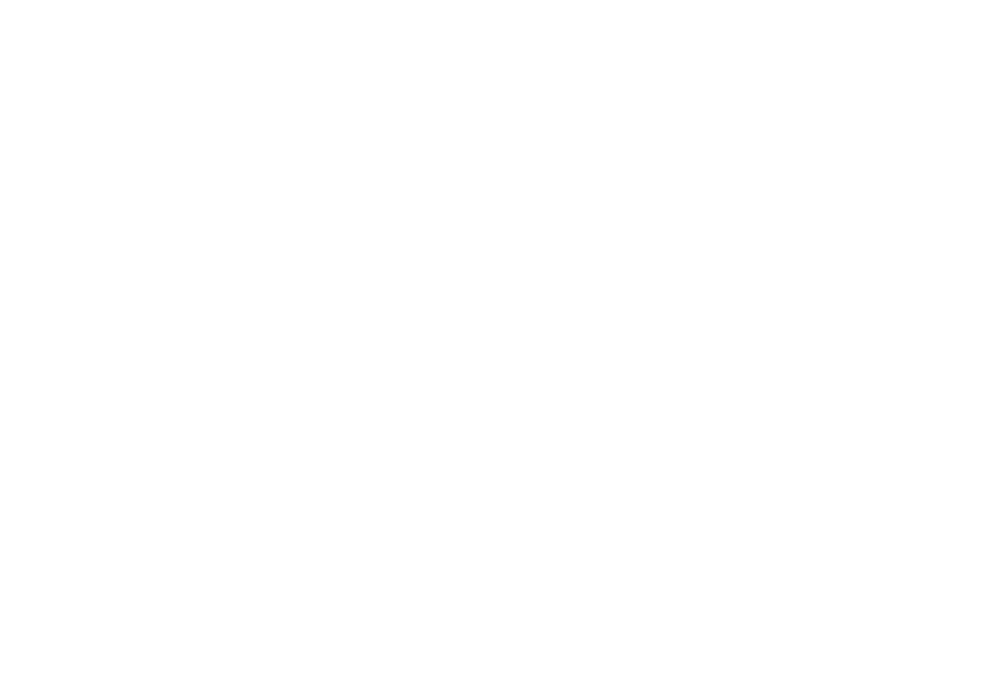

KeyboardInterrupt: 

In [168]:
#optional plot ice shelf masks and names
%matplotlib notebook

plt.close()
fig,ax = plt.subplots(figsize=(10,7))
grd.zice.where((grd.mask_rho==1)&(grd.zice<0)).plot(ax=ax,alpha=0.2,add_colorbar=False)

for name,data in log_progress(shelves.items()):
    
    grd.zice.where(data['mask']).plot(ax=ax,add_colorbar=False,alpha=0.5)
    ax.text(data['xi_mid'],data['eta_mid'],name,alpha=0.8)
    
ax.set_aspect('equal')
plt.tight_layout()

plt.show()

In [334]:
df_out_path = os.path.join(int_dir,'melt.csv')
df_melt.to_csv(df_out_path)#avg = xr.open_dataset(avg_path)

#m = avg.m.mean('ocean_time')

#s2a = 3600*24*365.25
#rhoi = 916

mask_ice = (grd.mask_rho==1) & (grd.zice<0)

for name,data in log_progress(shelves.items(),name='Ice shelf'): 

    mask = data['mask']

    dA = (1/(grd.pm*grd.pn)).where(mask)
    weights = dA/dA.sum()

    dA_l = dA.where(m > 0.0)
    weights_l = dA_l/dA.sum()

    dA_g = dA.where(m < 0.0)
    weights_g = dA_g/dA.sum()

    ismr2bmb = dA*rhoi*(10**-12)

    shelves[name]["A"] = dA.sum().values*10**-9
    shelves[name]["ismr"] = (m.where(mask)*weights).sum().values*s2a
    shelves[name]["ismr_l"] = (m.where(mask & (m > 0.0))*weights_l).sum().values*s2a
    shelves[name]["ismr_g"] = (m.where(mask & (m < 0.0))*weights_g).sum().values*s2a
    shelves[name]["bmb"] = (m.where(mask)*ismr2bmb).sum().values*s2a
    shelves[name]["bml"] = (m.where(mask & (m > 0.0))*ismr2bmb).sum().values*s2a
    shelves[name]["bmg"] = (m.where(mask & (m < 0.0))*ismr2bmb).sum().values*s2a
    shelves[name]['ismr_max'] = m.where(mask).max().values*s2a
    shelves[name]['ismr_min'] = m.where(mask).min().values*s2a

In [336]:
df = pd.DataFrame.from_dict(shelves, orient='index',
                            columns=['bmb','ismr','A','bml','bmg','ismr_l','ismr_g','ismr_max','ismr_min']).dropna()

In [337]:
pd.options.display.float_format = '{:,.2f}'.format
df.to_csv(os.path.join(int_dir,'2km _mass_loss_ant_bounds_all.csv'))
df

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
Abbot,72.11,2.71,29.02,72.11,-0.00,2.71,-0.00,17.37,-0.07
Abbot 1,0.12,0.69,0.20,0.12,0.00,0.69,0.00,3.18,0.13
Abbot 2,0.19,0.71,0.29,0.19,-0.00,0.71,-0.00,4.34,-0.06
Abbot 3,0.16,0.60,0.30,0.16,0.00,0.60,0.00,3.29,0.13
Abbot 4,0.36,1.07,0.37,0.36,0.00,1.07,0.00,4.06,0.14
Abbot 5,0.62,1.28,0.53,0.62,0.00,1.28,0.00,5.90,0.17
Abbot 6,0.12,0.64,0.20,0.12,0.00,0.64,0.00,1.98,0.06
Ainsworth,0.04,0.47,0.09,0.04,0.00,0.47,0.00,0.97,0.21
Alison,0.40,8.35,0.05,0.40,0.00,8.35,0.00,19.29,2.88
Amery,10.57,0.20,59.13,16.64,-6.07,0.31,-0.11,9.05,-16.92


In [29]:
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()
    
def combine_shelves(df,name):
    
    new_data = {}
    
    for key in ['bmb','bml','bmg','A']:
        new_data[key]=df[key].sum()
    for key in ['ismr','ismr_l','ismr_g']:
        new_data[key]=wavg(df,key,'A')
        
    new_data['ismr_max']=df['ismr_max'].max()
    new_data['ismr_min']=df['ismr_min'].min()
    
    new_dict = {name:{'bmb':new_data['bmb'],'ismr':new_data['ismr'],'A':new_data['A'],
                      'bml':new_data['bml'],'bmg':new_data['bmg'],
                      'ismr_l':new_data['ismr_l'],'ismr_g':new_data['ismr_g'],
                      'ismr_max':new_data['ismr_max'],'ismr_min':new_data['ismr_min']}}
    new_df = pd.DataFrame.from_dict(new_dict, orient='index',
                                    columns=['bmb','ismr','A','bml','bmg',
                                             'ismr_l','ismr_g','ismr_max','ismr_min'])
    
    return new_df

In [355]:
ant_bounds_comb = combine_shelves(df,'Ant_bounds all')
ant_bounds_comb

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
Ant_bounds all,974.01,0.70,"1,523.33","1,026.62",-52.61,0.74,-0.04,63.18,-16.92


# following Rignot 2013

In [340]:
def select_names(df,names):
    df_select = df[df.index.str.contains('bla')]
    for string in names:
        df_select = df_select.append(df[df.index.str.contains(string)])
    return df_select

In [341]:
AP_names = ['LarsenG','LarsenF','LarsenE','LarsenD','LarsenC','LarsenB','Wordie','Wilkins','Bach','George VI','Stange']
select_names(df,AP_names)

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
LarsenG,0.05,0.13,0.39,0.06,-0.01,0.16,-0.03,0.49,-0.38
LarsenF,0.23,0.32,0.79,0.27,-0.04,0.38,-0.06,2.93,-0.81
LarsenE,0.87,0.82,1.15,1.00,-0.13,0.95,-0.12,6.15,-1.63
LarsenD,5.49,0.28,21.64,6.92,-1.42,0.35,-0.07,3.78,-2.60
LarsenD 1,0.01,0.30,0.04,0.01,0.00,0.30,0.00,0.67,0.02
LarsenC,9.09,0.22,45.62,10.15,-1.07,0.24,-0.03,4.96,-2.74
LarsenB,0.69,0.37,2.03,0.69,-0.00,0.37,-0.00,2.26,-0.12
Wordie (Harriott Headland),0.00,0.13,0.04,0.00,0.00,0.13,0.00,0.18,0.08
Wordie (Harriott),0.01,0.21,0.07,0.01,0.00,0.21,0.00,0.36,0.11
Wordie (Prospect),0.03,0.19,0.16,0.03,-0.00,0.19,-0.00,0.52,-0.02


In [342]:
AP = pd.concat([select_names(df,['LarsenG','LarsenF','LarsenE']),
              combine_shelves(select_names(df,['LarsenD']),'Larsen D'),
              select_names(df,['LarsenC']),
              combine_shelves(select_names(df,['Wordie']),'Wordie'),
              select_names(df,['Wilkins','Bach','George VI','Stange'])])
AP

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
LarsenG,0.05,0.13,0.39,0.06,-0.01,0.16,-0.03,0.49,-0.38
LarsenF,0.23,0.32,0.79,0.27,-0.04,0.38,-0.06,2.93,-0.81
LarsenE,0.87,0.82,1.15,1.00,-0.13,0.95,-0.12,6.15,-1.63
Larsen D,5.50,0.28,21.68,6.93,-1.42,0.35,-0.07,3.78,-2.60
LarsenC,9.09,0.22,45.62,10.15,-1.07,0.24,-0.03,4.96,-2.74
Wordie,0.05,0.19,0.27,0.05,-0.00,0.19,-0.00,0.52,-0.02
Wilkins,15.86,1.36,12.70,15.87,-0.01,1.36,-0.00,9.24,-0.38
Bach,12.93,3.15,4.49,13.00,-0.07,3.16,-0.02,42.65,-3.51
George VI,146.09,7.00,22.79,146.12,-0.03,7.00,-0.00,50.17,-3.52
Stange,14.72,2.06,7.80,14.72,-0.00,2.06,-0.00,12.54,-0.01


In [343]:
AP_comb = combine_shelves(AP,'AP')
AP_comb

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
AP,205.38,1.91,117.68,208.16,-2.79,1.93,-0.03,50.17,-3.52


In [344]:
WAIS_names = ['Ronne','Ferrigno','Venable','Abbot','Cosgrove','Pine Island','Thwaites','Crosson','Dotson','Getz',
              'Land','Nickerson','Sulzberger','Swinburne','Withrow','Ross West']
select_names(df,WAIS_names)

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
Ronne,84.11,0.28,332.38,105.36,-21.24,0.35,-0.07,19.55,-14.56
Ferrigno,1.12,10.83,0.11,1.12,0.00,10.83,0.00,19.64,2.97
Venable,13.91,4.85,3.13,13.91,-0.00,4.85,-0.00,28.20,-0.22
Abbot,72.11,2.71,29.02,72.11,-0.00,2.71,-0.00,17.37,-0.07
Abbot 1,0.12,0.69,0.20,0.12,0.00,0.69,0.00,3.18,0.13
Abbot 2,0.19,0.71,0.29,0.19,-0.00,0.71,-0.00,4.34,-0.06
Abbot 3,0.16,0.60,0.30,0.16,0.00,0.60,0.00,3.29,0.13
Abbot 4,0.36,1.07,0.37,0.36,0.00,1.07,0.00,4.06,0.14
Abbot 5,0.62,1.28,0.53,0.62,0.00,1.28,0.00,5.90,0.17
Abbot 6,0.12,0.64,0.20,0.12,0.00,0.64,0.00,1.98,0.06


In [345]:
WAIS = pd.concat([select_names(df,['Ronne','Ferrigno','Venable']),
              combine_shelves(select_names(df,['Abbot']),'Abbot'),
              select_names(df,['Cosgrove','Pine Island','Thwaites','Crosson','Dotson']),
              combine_shelves(select_names(df,['Getz']),'Getz'),
              select_names(df,['Nickerson','Sulzberger','Swinburne','Withrow','Ross West'])])
WAIS

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
Ronne,84.11,0.28,332.38,105.36,-21.24,0.35,-0.07,19.55,-14.56
Ferrigno,1.12,10.83,0.11,1.12,0.00,10.83,0.00,19.64,2.97
Venable,13.91,4.85,3.13,13.91,-0.00,4.85,-0.00,28.20,-0.22
Abbot,73.68,2.60,30.90,73.68,-0.00,2.60,-0.00,17.37,-0.07
Cosgrove,7.97,2.97,2.93,7.97,0.00,2.97,0.00,20.28,0.09
Pine Island,36.68,7.04,5.69,36.68,-0.00,7.04,-0.00,63.18,-0.19
Thwaites,31.50,8.40,4.09,31.51,-0.02,8.41,-0.00,36.83,-1.79
Crosson,1.41,0.54,2.84,1.63,-0.22,0.63,-0.08,3.92,-0.97
Dotson,3.41,0.73,5.09,3.64,-0.23,0.78,-0.05,7.45,-2.82
Getz,60.16,1.99,33.05,60.52,-0.36,2.00,-0.01,21.70,-2.06


In [346]:
WAIS_comb = combine_shelves(WAIS,'WAIS')
WAIS_comb

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
WAIS,425.58,0.63,741.61,452.79,-27.22,0.67,-0.04,63.18,-14.56


In [347]:
EAIS_names = ['Ross East','Drygalski','Nansen','Aviator','Mariner','Lillie','Rennick','Cook','Ninnis','Mertz',
              'Dibble','Holmes','Moscow University','Totten','Vincennes','Conger','Tracy','Shackleton','West',
              'Publications','Amery','Wilma','Edward','Rayner','Shirase','Prince Harald','Baudouin','Borchgrevink',
              'Lazarev','Nivl','Vigrid','Fimbul','Jelbart','Atka','Ekstrom','Quar','Riiser','Brunt','Filchner']
select_names(df,EAIS_names)

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
Ross East,25.15,0.15,188.75,27.37,-2.22,0.16,-0.01,10.56,-2.51
Drygalski,1.75,0.85,2.24,1.82,-0.07,0.89,-0.04,6.25,-2.28
Nansen,0.14,0.08,1.86,0.28,-0.14,0.16,-0.08,1.14,-0.63
Aviator,0.24,0.34,0.77,0.27,-0.04,0.39,-0.05,1.35,-0.42
Mariner,1.74,0.72,2.65,1.88,-0.14,0.77,-0.06,7.56,-1.25
Lillie,1.68,2.49,0.74,1.69,-0.00,2.50,-0.01,14.63,-0.52
Rennick,0.74,0.25,3.21,1.09,-0.36,0.37,-0.12,2.47,-1.69
Cook,10.64,3.49,3.33,10.64,0.00,3.49,0.00,14.17,0.03
Ninnis,4.26,2.65,1.75,4.26,0.00,2.65,0.00,6.48,0.16
Mertz,6.61,1.36,5.31,6.74,-0.13,1.39,-0.03,6.54,-0.80


In [348]:
EAIS = select_names(df,EAIS_names).drop('Ross West')
EAIS

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
Ross East,25.15,0.15,188.75,27.37,-2.22,0.16,-0.01,10.56,-2.51
Drygalski,1.75,0.85,2.24,1.82,-0.07,0.89,-0.04,6.25,-2.28
Nansen,0.14,0.08,1.86,0.28,-0.14,0.16,-0.08,1.14,-0.63
Aviator,0.24,0.34,0.77,0.27,-0.04,0.39,-0.05,1.35,-0.42
Mariner,1.74,0.72,2.65,1.88,-0.14,0.77,-0.06,7.56,-1.25
Lillie,1.68,2.49,0.74,1.69,-0.00,2.50,-0.01,14.63,-0.52
Rennick,0.74,0.25,3.21,1.09,-0.36,0.37,-0.12,2.47,-1.69
Cook,10.64,3.49,3.33,10.64,0.00,3.49,0.00,14.17,0.03
Ninnis,4.26,2.65,1.75,4.26,0.00,2.65,0.00,6.48,0.16
Mertz,6.61,1.36,5.31,6.74,-0.13,1.39,-0.03,6.54,-0.80


In [349]:
EAIS_comb = combine_shelves(EAIS,'EAIS')
EAIS_comb

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
EAIS,322.48,0.54,650.82,345.07,-22.60,0.58,-0.04,24.60,-16.92


In [352]:
Rignot_comb = combine_shelves(pd.concat([AP_comb,WAIS_comb,EAIS_comb]),'Rignot all')
Rignot_comb

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
Rignot all,953.43,0.69,"1,510.10","1,006.03",-52.60,0.73,-0.04,63.18,-16.92


In [356]:
df_out = pd.concat([AP,AP_comb,
           WAIS,WAIS_comb,
           EAIS,EAIS_comb,
           Rignot_comb,
           ant_bounds_comb,
           all_ice])
df_out

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
LarsenG,0.05,0.13,0.39,0.06,-0.01,0.16,-0.03,0.49,-0.38
LarsenF,0.23,0.32,0.79,0.27,-0.04,0.38,-0.06,2.93,-0.81
LarsenE,0.87,0.82,1.15,1.00,-0.13,0.95,-0.12,6.15,-1.63
Larsen D,5.50,0.28,21.68,6.93,-1.42,0.35,-0.07,3.78,-2.60
LarsenC,9.09,0.22,45.62,10.15,-1.07,0.24,-0.03,4.96,-2.74
Wordie,0.05,0.19,0.27,0.05,-0.00,0.19,-0.00,0.52,-0.02
Wilkins,15.86,1.36,12.70,15.87,-0.01,1.36,-0.00,9.24,-0.38
Bach,12.93,3.15,4.49,13.00,-0.07,3.16,-0.02,42.65,-3.51
George VI,146.09,7.00,22.79,146.12,-0.03,7.00,-0.00,50.17,-3.52
Stange,14.72,2.06,7.80,14.72,-0.00,2.06,-0.00,12.54,-0.01


In [357]:
csv_out_path = os.path.join(pro_dir,'2km_mass_loss.csv')
df_out.to_csv(csv_out_path)

# Major ice shelves for comparison

In [245]:
names = ['George','Abbot','Pine','Getz','Fimbul','Jelbart','Brunt','Riiser','Filchner','Ronne','LarsenC','Ross',
                   'Totten','Moscow','Shackleton','Amery']
major = select_names(df,names)     

In [246]:
def merge_shelves(df,name1,name2,name):
    
    p1 = df.loc[name1]
    p2 = df.loc[name2]
    
    new_data = {}
    for key in ['bmb','bml','bmg','A']:
        new_data[key]=p1[key]+p2[key]
    for key in ['ismr','ismr_l','ismr_g']:
        new_data[key]=(p1[key]*p1['A']+p2[key]*p2['A'])/(p1['A']+p2['A'])
        
    new_data['ismr_max']=np.max([p1['ismr_max'],p2['ismr_max']])
    new_data['ismr_min']=np.max([p1['ismr_min'],p2['ismr_min']])
    
    new_dict = {name:{'bmb':new_data['bmb'],'ismr':new_data['ismr'],'A':new_data['A'],
                      'bml':new_data['bml'],'bmg':new_data['bmg'],
                      'ismr_l':new_data['ismr_l'],'ismr_g':new_data['ismr_g'],
                      'ismr_max':new_data['ismr_max'],'ismr_min':new_data['ismr_min']}}
    new_df = pd.DataFrame.from_dict(new_dict, orient='index',columns=['bmb','ismr','A','bml','bmg','ismr_l','ismr_g','ismr_max','ismr_min'])
    df = df.drop([name1,name2])
    df = df.append(new_df)
    
    return df

In [247]:
major = merge_shelves(major,'Abbot','Abbot 1','Abbot')
for key in ['2','3','4','5','6']:
    major = merge_shelves(major,'Abbot','Abbot '+key,'Abbot')
major

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
George VI,145.99,6.99,22.79,146.02,-0.03,7.00,-0.00,50.14,-3.52
Pine Island,36.65,7.03,5.69,36.65,-0.00,7.04,-0.00,63.13,-0.19
Getz,59.76,2.00,32.54,60.12,-0.36,2.02,-0.01,21.69,-2.06
Getz 1,0.36,0.78,0.51,0.36,0.00,0.78,0.00,2.70,0.04
Fimbul,53.89,1.47,39.92,53.95,-0.06,1.48,-0.00,24.58,-3.12
Jelbart,9.04,0.93,10.61,9.36,-0.31,0.96,-0.03,11.70,-1.18
Brunt Stancomb,33.52,1.02,36.00,33.69,-0.17,1.02,-0.01,19.07,-0.53
Riiser-Larsen,31.01,0.79,42.85,32.51,-1.50,0.83,-0.04,17.51,-5.67
Filchner,6.19,0.07,100.95,13.31,-7.12,0.14,-0.08,8.00,-5.25
Ronne,84.05,0.28,332.38,105.28,-21.23,0.35,-0.07,19.54,-14.55


In [248]:
major = merge_shelves(major,'Filchner','Ronne','Filchner-Ronne')
major = merge_shelves(major,'Getz','Getz 1','Getz')
major = merge_shelves(major,'Fimbul','Jelbart','Fimbul + Jelbart')
major = merge_shelves(major,'Brunt Stancomb','Riiser-Larsen','Brunt + Riiser-Larsen')
major = merge_shelves(major,'Ross East','Ross West','Ross')
major = merge_shelves(major,'Totten','Moscow University','Totten + Moscow Uni')

In [249]:
major

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
George VI,145.99,6.99,22.79,146.02,-0.03,7.00,-0.00,50.14,-3.52
Pine Island,36.65,7.03,5.69,36.65,-0.00,7.04,-0.00,63.13,-0.19
LarsenC,9.08,0.22,45.62,10.14,-1.06,0.24,-0.03,4.95,-2.74
Shackleton,17.12,0.74,25.26,18.29,-1.18,0.79,-0.05,10.81,-2.15
Amery,10.56,0.19,59.13,16.63,-6.07,0.31,-0.11,9.04,-16.91
Abbot,73.63,2.60,30.90,73.63,-0.00,2.60,-0.00,17.35,0.17
Filchner-Ronne,90.25,0.23,433.32,118.60,-28.35,0.30,-0.07,19.54,-5.25
Getz,60.12,1.99,33.05,60.48,-0.36,2.00,-0.01,21.69,0.04
Fimbul + Jelbart,62.94,1.36,50.54,63.31,-0.37,1.37,-0.01,24.58,-1.18
Brunt + Riiser-Larsen,64.53,0.89,78.86,66.20,-1.67,0.92,-0.02,19.07,-0.53


In [358]:
csv_select_pro_path = os.path.join(pro_dir,'2km_mass_loss_major.csv')
major.to_csv(csv_select_pro_path)

In [201]:
major_comb = combine_shelves(major,'major')
major_comb

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
major,543.24,0.72,828.57,562.54,-19.31,0.74,-0.03,63.13,-16.91


# Major Ice shelves after ocean and size

In [203]:
names = ['George','Wilkins','Bach','Stange','Ferrigno',
        'Venable','Abbot','Cosgrove','Pine','Thwaits','Crosson',
         'Dotson','Getz','Land']
warm_AB = select_names(df,names)
warm_AB

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
George VI,145.99,6.99,22.79,146.02,-0.03,7.00,-0.00,50.14,-3.52
Wilkins,15.85,1.36,12.70,15.86,-0.01,1.36,-0.00,9.23,-0.38
Bach,12.92,3.14,4.49,12.99,-0.07,3.16,-0.02,42.62,-3.51
Stange,14.71,2.06,7.80,14.71,-0.00,2.06,-0.00,12.54,-0.01
Ferrigno,1.12,10.83,0.11,1.12,0.00,10.83,0.00,19.63,2.97
Venable,13.90,4.84,3.13,13.90,-0.00,4.84,-0.00,28.18,-0.22
Abbot,72.06,2.71,29.02,72.06,-0.00,2.71,-0.00,17.35,-0.07
Abbot 1,0.12,0.69,0.20,0.12,0.00,0.69,0.00,3.18,0.13
Abbot 2,0.19,0.71,0.29,0.19,-0.00,0.71,-0.00,4.33,-0.06
Abbot 3,0.16,0.60,0.30,0.16,0.00,0.60,0.00,3.29,0.13


In [230]:
warm_AB_comb = combine_shelves(warm_AB,'Amunden-Bellinghausen')
warm_AB_comb

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
Amunden-Bellinghausen,390.94,3.23,132.15,391.87,-0.93,3.24,-0.01,63.13,-3.52


In [205]:
names = ['Filchner','Ronne','Ross','LarsenC','Amery']
large_cold = select_names(df,names)
large_cold

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
Filchner,6.19,0.07,100.95,13.31,-7.12,0.14,-0.08,8.00,-5.25
Ronne,84.05,0.28,332.38,105.28,-21.23,0.35,-0.07,19.54,-14.55
Ross East,25.13,0.15,188.75,27.35,-2.22,0.16,-0.01,10.55,-2.51
Ross West,41.35,0.15,301.65,46.49,-5.14,0.17,-0.02,10.25,-1.76
LarsenC,9.08,0.22,45.62,10.14,-1.06,0.24,-0.03,4.95,-2.74
Amery,10.56,0.19,59.13,16.63,-6.07,0.31,-0.11,9.04,-16.91


In [207]:
large_cold_comb = combine_shelves(large_cold,'large cold')
large_cold_comb

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
large cold,176.36,0.19,"1,028.48",219.20,-42.84,0.23,-0.05,19.54,-16.91


In [180]:
names = ['Nickerson','Sulzberg','Swinburne','Withrow','Drygal','Nansen',
         'Aviator','Mariner']
small_RS = select_names(df,names)
small_RS

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
Nickerson,22.29,3.83,6.35,22.29,-0.00,3.83,-0.00,16.03,-0.25
Sulzberger,40.90,3.73,11.96,40.90,-0.00,3.73,-0.00,25.68,-0.06
Swinburne,6.05,8.03,0.82,6.05,0.00,8.03,0.00,24.31,0.03
Withrow,0.96,1.69,0.62,0.96,0.00,1.69,0.00,4.49,0.14
Drygalski,1.75,0.85,2.24,1.82,-0.07,0.89,-0.04,6.25,-2.28
Nansen,0.14,0.08,1.86,0.28,-0.14,0.16,-0.08,1.13,-0.63
Aviator,0.24,0.34,0.77,0.27,-0.04,0.39,-0.05,1.35,-0.42
Mariner,1.73,0.71,2.65,1.88,-0.14,0.77,-0.06,7.56,-1.25


In [210]:
small_RS_comb = combine_shelves(small_RS,'Small Ross Sea')
small_RS_comb

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
Small Ross Sea,74.06,2.97,27.27,74.45,-0.39,2.98,-0.02,25.68,-2.28


In [185]:
names = ['Lillie','Rennick','Cook','Mertz','Dibble',
         'Holmes','Moscow','Totten','Vincennes','Conger','Tremenchus',
        'Shackleton']
small_EI = select_names(df,names)
small_EI

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
Lillie,1.68,2.49,0.74,1.69,-0.00,2.50,-0.01,14.62,-0.52
Rennick,0.73,0.25,3.21,1.09,-0.36,0.37,-0.12,2.47,-1.69
Cook,10.64,3.49,3.33,10.64,0.00,3.49,0.00,14.16,0.03
Mertz,6.60,1.36,5.31,6.73,-0.13,1.39,-0.03,6.54,-0.80
Dibble,3.29,2.55,1.41,3.29,-0.00,2.55,-0.00,11.67,-0.12
Holmes,3.36,1.71,2.14,3.36,0.00,1.71,0.00,8.36,0.03
Moscow University,6.41,1.23,5.68,7.75,-1.34,1.49,-0.26,10.46,-5.76
Totten,6.85,1.26,5.92,7.88,-1.03,1.45,-0.19,10.69,-6.12
Vincennes Bay,1.64,1.98,0.91,1.64,0.00,1.98,0.00,9.15,0.25
Conger Glenzer,5.02,3.58,1.53,5.02,0.00,3.58,0.00,9.94,0.62


In [211]:
small_EI_comb = combine_shelves(small_EI,'small East Indien')
small_EI_comb

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
small East Indien,65.48,1.23,58.16,69.63,-4.15,1.31,-0.08,14.62,-6.12


In [190]:
names = ['Vigrid','Nivl','Lazarev','Borch','Bau','Prince','Shirase',
         'Rayner','Edward','Wilma','Publications','West']
small_WI = select_names(df,names).drop('Ross West')
small_WI

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
Vigrid,1.53,0.83,2.01,1.53,-0.00,0.83,-0.00,4.25,-0.05
Nivl,2.11,0.32,7.14,2.19,-0.08,0.33,-0.01,4.75,-0.81
Lazarev,3.05,0.40,8.35,3.22,-0.17,0.42,-0.02,3.66,-0.42
Borchgrevink,18.59,0.99,20.43,18.61,-0.01,0.99,-0.00,11.46,-0.48
Baudouin,17.93,0.60,32.37,17.94,-0.01,0.61,-0.00,5.51,-0.10
Prince Harald,5.81,1.25,5.06,5.81,0.00,1.25,0.00,6.56,0.03
Shirase,1.04,1.74,0.65,1.04,-0.00,1.74,-0.00,6.70,-0.04
Rayner Thyer,0.16,0.29,0.61,0.17,-0.01,0.30,-0.01,2.47,-0.16
Edward VIII,0.31,0.85,0.39,0.31,-0.00,0.85,-0.00,3.86,-0.00
WilmaRobertDowner,0.39,0.53,0.80,0.39,-0.00,0.53,-0.00,3.50,-0.13


In [212]:
small_WI_comb = combine_shelves(small_WI,'Small West Indian')
small_WI_comb

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
Small West Indian,71.24,0.82,94.37,71.54,-0.29,0.83,-0.00,11.46,-0.81


In [193]:
names = ['LarsenB','LarsenD','LarsenE','LarsenF','LarsenG',
         'Stancomb','Riiser','Quar','Ekstr','Atka','Jelbart','Fimbul']
small_WS = select_names(df,names)
small_WS

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
LarsenB,0.69,0.37,2.03,0.69,-0.00,0.37,-0.00,2.26,-0.12
LarsenD,5.49,0.28,21.64,6.91,-1.42,0.35,-0.07,3.78,-2.59
LarsenD 1,0.01,0.30,0.04,0.01,0.00,0.30,0.00,0.67,0.02
LarsenE,0.87,0.82,1.15,1.00,-0.13,0.94,-0.12,6.15,-1.63
LarsenF,0.23,0.32,0.79,0.27,-0.04,0.38,-0.06,2.92,-0.81
LarsenG,0.05,0.13,0.39,0.06,-0.01,0.16,-0.03,0.49,-0.38
Brunt Stancomb,33.52,1.02,36.00,33.69,-0.17,1.02,-0.01,19.07,-0.53
Riiser-Larsen,31.01,0.79,42.85,32.51,-1.50,0.83,-0.04,17.51,-5.67
Quar,2.00,1.03,2.11,2.00,0.00,1.03,0.00,5.00,0.02
Ekstrom,4.82,0.78,6.74,5.11,-0.29,0.83,-0.05,7.58,-1.22


In [213]:
small_WS_comb = combine_shelves(small_WS,'Small Weddell Sea')
small_WS_comb

,bmb,ismr,A,bml,bmg,ismr_l,ismr_g,ismr_max,ismr_min
Small Weddell Sea,142.87,0.94,166.23,146.82,-3.94,0.96,-0.03,24.58,-5.67


In [236]:
comb_all = combine_shelves(pd.concat([warm_AB_comb,large_cold_comb,small_EI_comb,small_WI_comb,small_WS_comb]),'combined all')
comb_small = combine_shelves(pd.concat([small_EI_comb,small_WI_comb,small_WS_comb]),'combined small')

In [359]:
regime_df = pd.concat([warm_AB_comb,large_cold_comb,small_EI_comb,small_WI_comb,small_WS_comb,comb_small,comb_all])
out_path = os.path.join(pro_dir,'2km_mass_loss_regime.csv')
regime_df.to_csv(out_path)

<IPython.core.display.Javascript object>


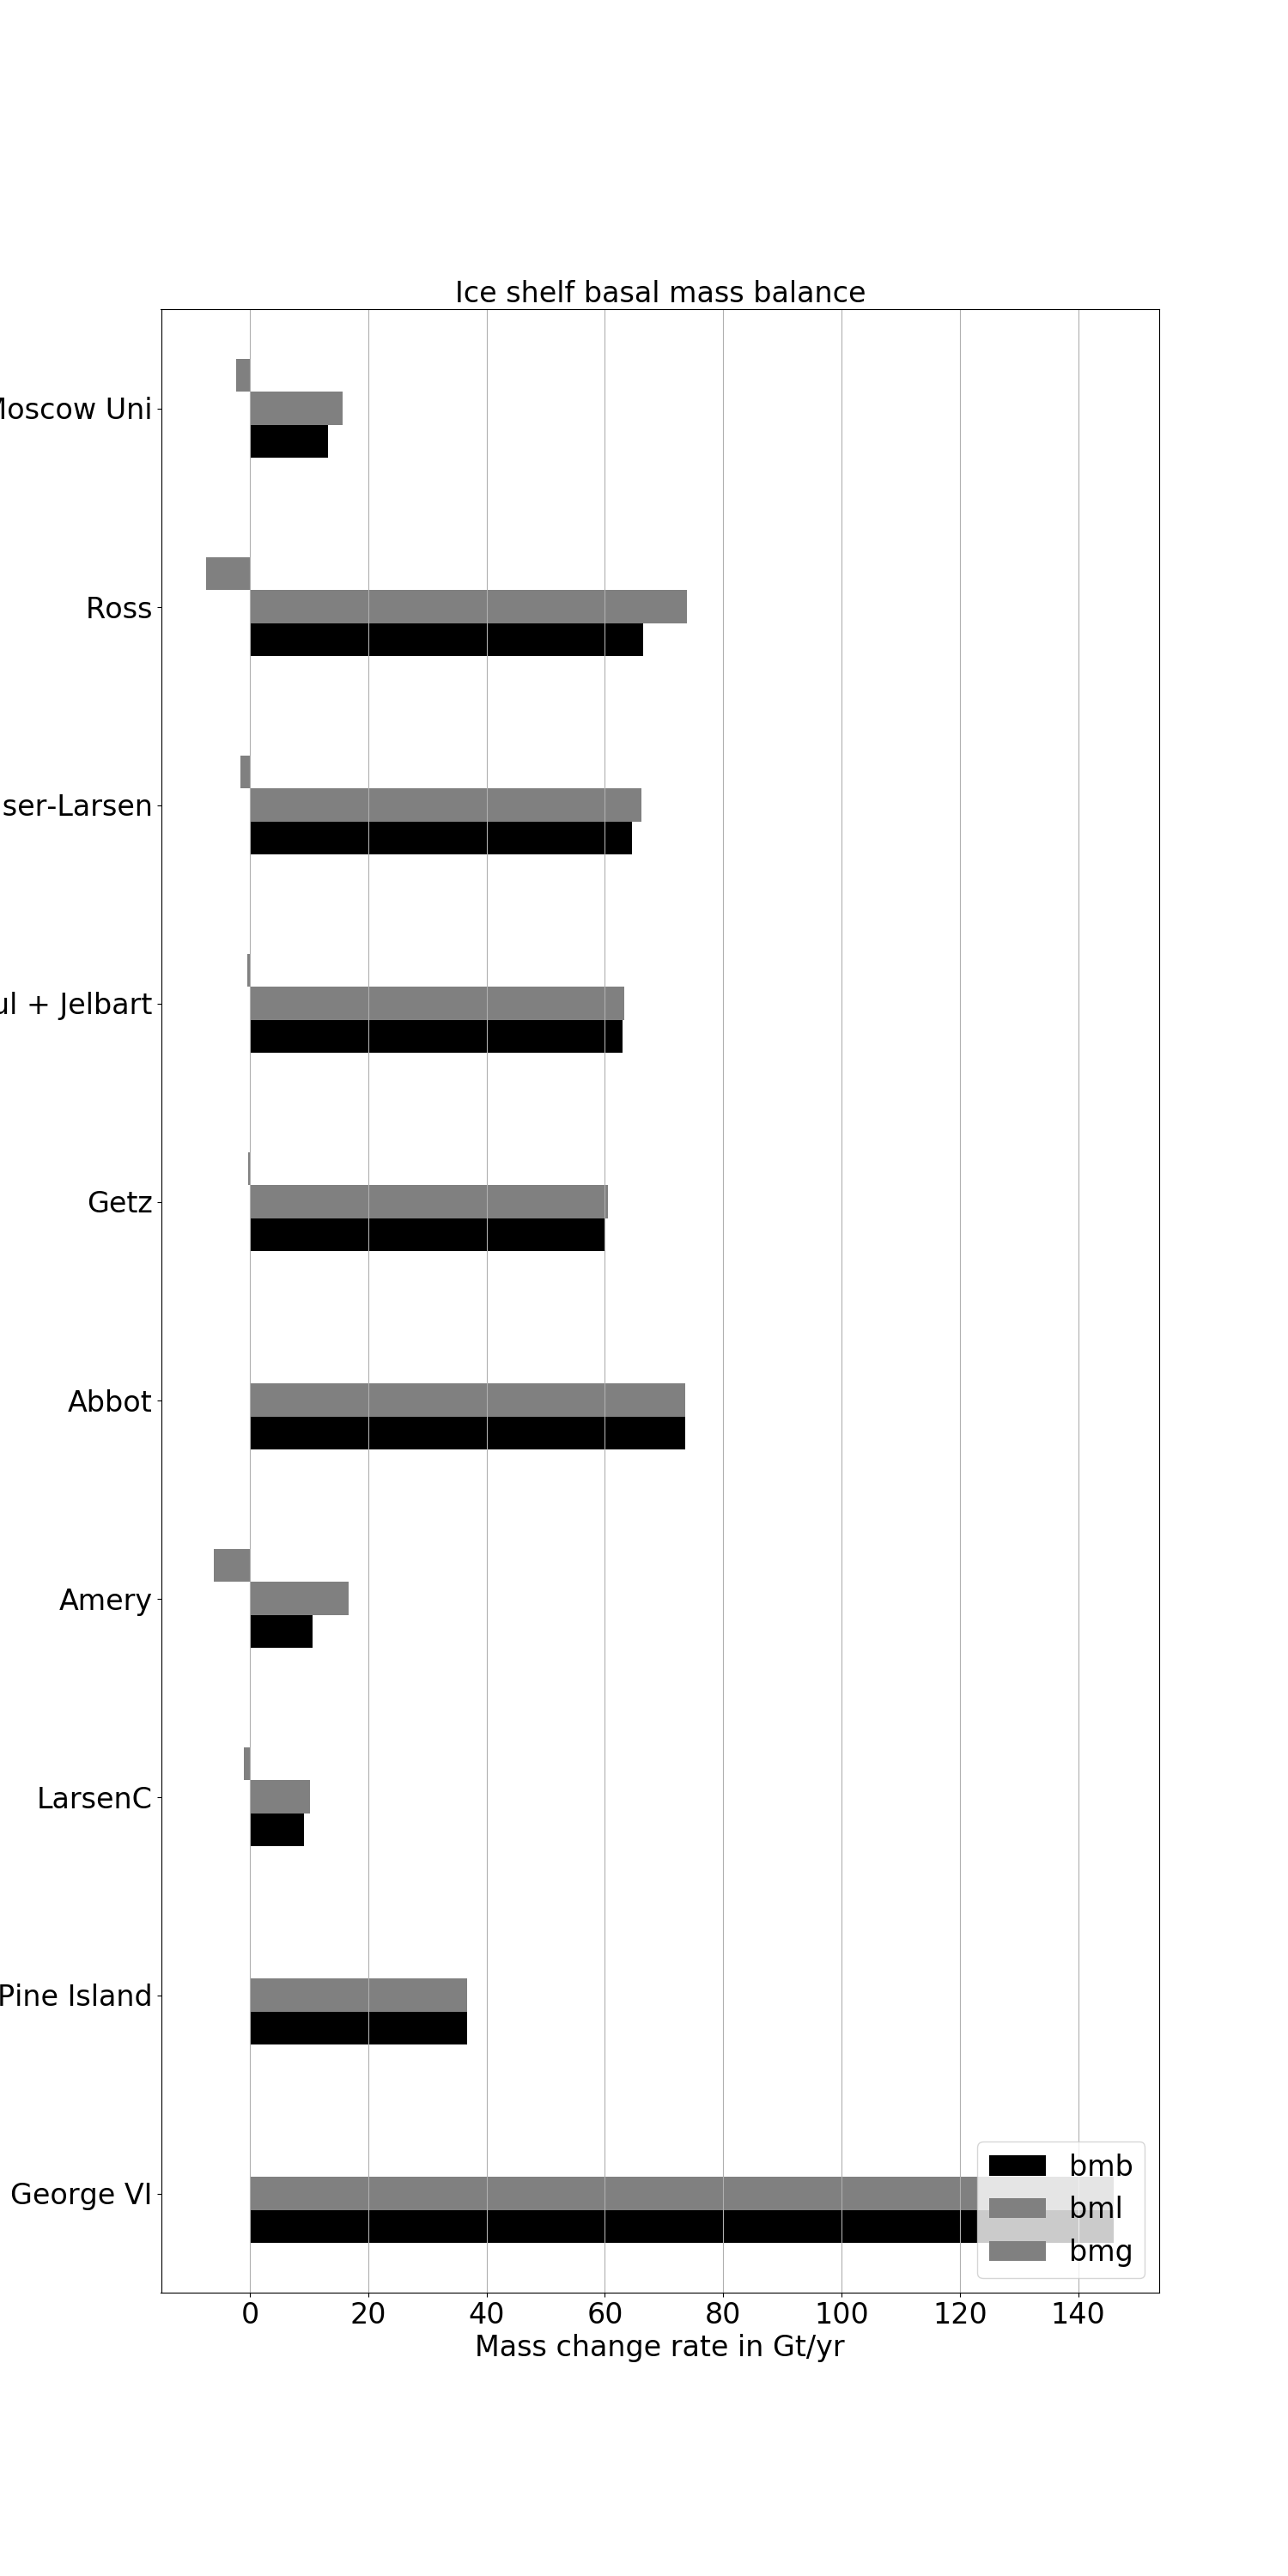

In [104]:
out_path = os.path.join(fig_dir,'bmb2_select.png')

plt.close()
fig,ax = plt.subplots(figsize=(15,30))
df_select.plot(y=['bmb','bml','bmg'],kind='barh',ax=ax,fontsize=24,color=['black','gray','gray'])
ax.legend(markerscale=1,fontsize=24,loc=4)
ax.set_title('Ice shelf basal mass balance',fontsize=24)
ax.set_xlabel('Mass change rate in Gt/yr',fontsize=24)
ax.grid(axis='x')
#plt.savefig(out_path,dpi=300,format='png', bbox_inches='tight')
plt.show()

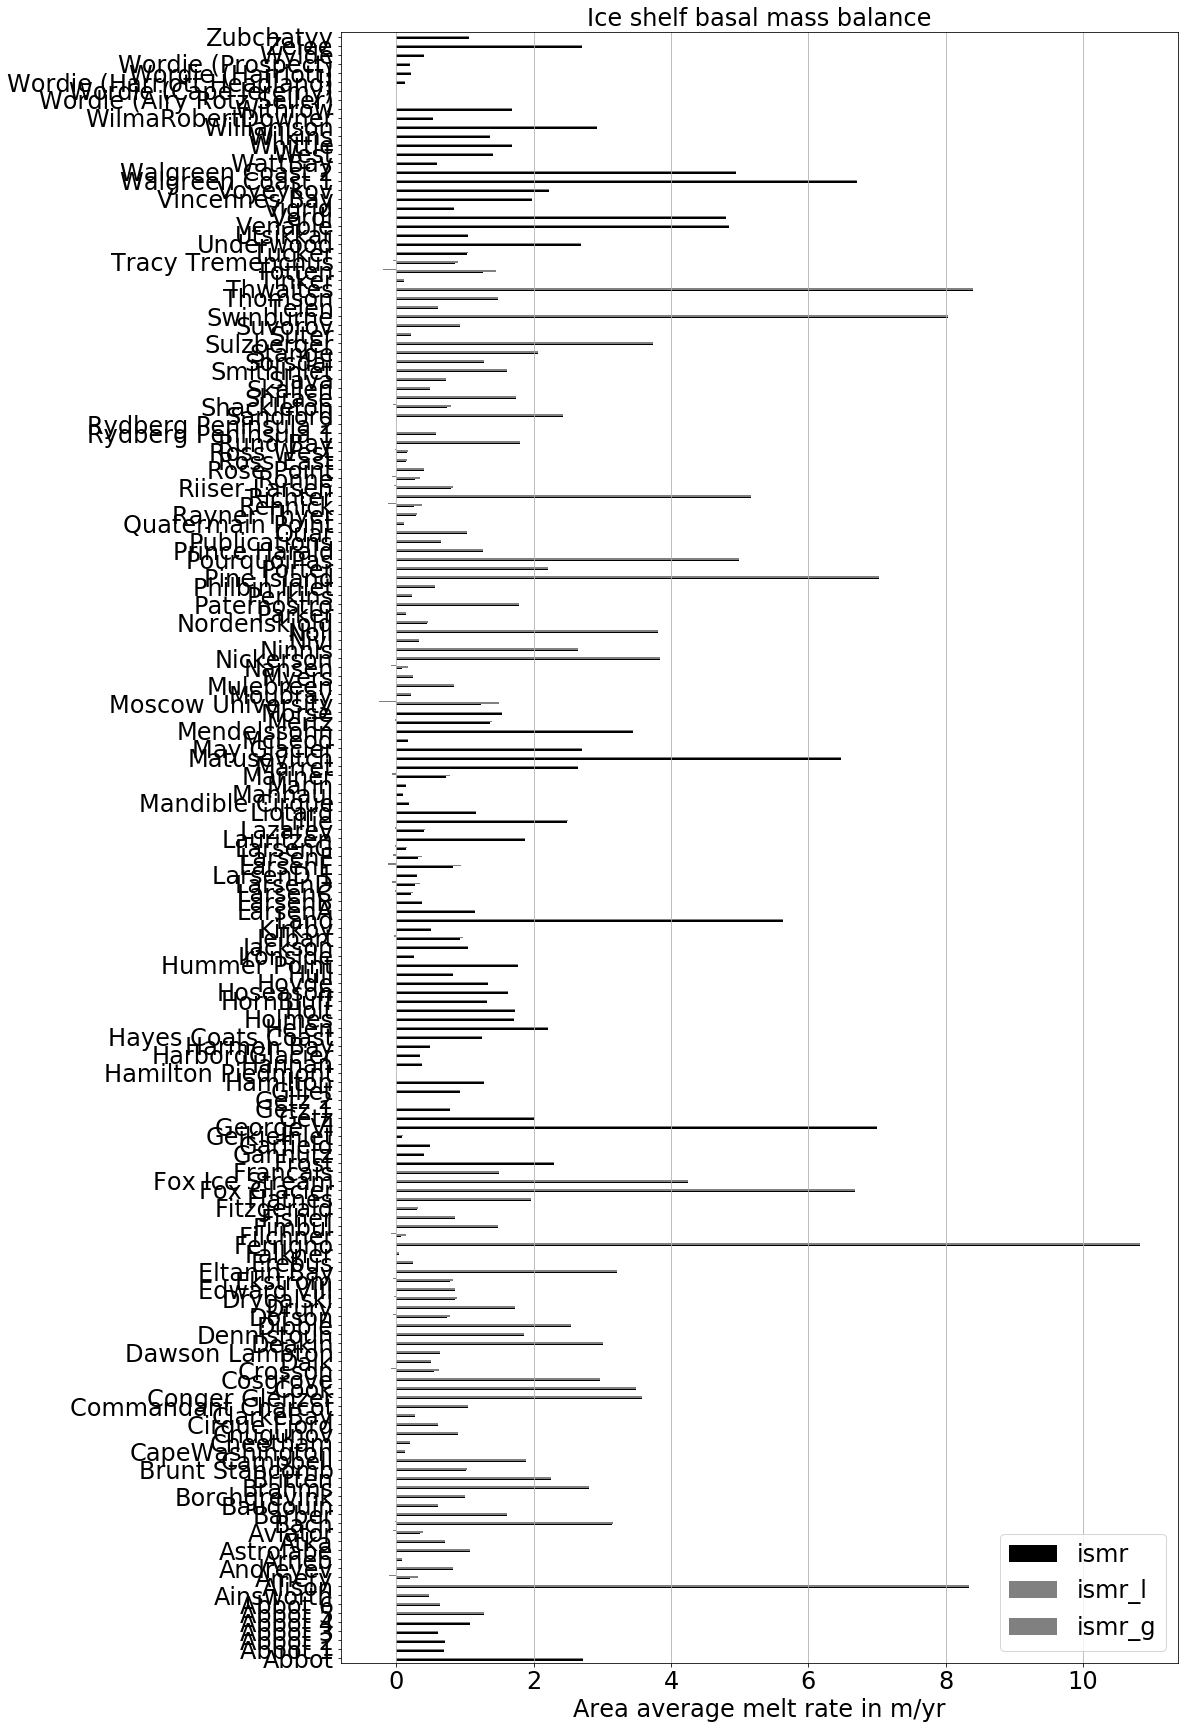

In [31]:
out_path = os.path.join(fig_dir,'ismr_all_2.png')

plt.close()
fig,ax = plt.subplots(figsize=(15,30))
df.plot(y=['ismr','ismr_l','ismr_g'],kind='barh',ax=ax,fontsize=24,color=['black','gray','gray'])
ax.legend(markerscale=1,fontsize=24,loc=4)
ax.set_title('Ice shelf basal mass balance',fontsize=24)
ax.set_xlabel('Area average melt rate in m/yr',fontsize=24)
ax.grid(axis='x')
plt.savefig(out_path,dpi=300,format='png', bbox_inches='tight')
plt.show()

def make_mask_front(grd,nb_cells):
    
    mask_rho = grd.mask_rho.values
    mask_land = np.zeros_like(mask_rho)
    mask_land[mask_rho == 0] = 1
    mask_zice = np.zeros_like(mask_land)
    mask_zice[grd.zice.values*mask_rho != 0] = 1

    mask_front = np.zeros_like(grd.mask_rho.values)

    for j in grd.eta_rho.values:
        for i in grd. xi_rho.values:
            if mask_zice[j,i] == 1:
                j_min = max(j-nb_cells,0)
                j_max = min(j+nb_cells, np.size(mask_rho,0))
                i_min = max(i-nb_cells,0)
                i_max = min(i+nb_cells+1, np.size(mask_rho,1))

                if np.any(mask_zice[j_min:j_max,i_min:i_max] + mask_land[j_min:j_max,i_min:i_max]== 0):
                        mask_front[j,i] = 1
                        
    grd['mask_front'] = (('eta_rho','xi_rho'),mask_front)
    
    return grd
grd = make_mask_front(grd,3)

%matplotlib notebook
s2a = 3600*24*365
(m*s2a).where((grd.mask_rho==1) & (grd.zice<0.0)).plot(vmin=-2,vmax=2,cmap="bwr")
grd.mask_front.plot.contour(alpha=0.3)
plt.show()